# ABC with the OpenCL RAMP model

Multi-paramter calibration of the RAMP model using Approximate Bayesian Computation

Based on [abc-1.ipynb](abc-1.ipynb). See that file for a more detailed technical description. This file calibrates on the location-specific hazard multipliers (e.g. to see if the algorithm can work out how hazardous the different location types are).

**Location hazards:

These are multipliers associated with locations (i.e. make some locations contribute more to the disease risk than others).

 - Home
  - Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0.
 - Retail:
  - Uniform between 0 and 1.
 - PrimarySchool: 1.0
  - Uniform between 0 and 1.
 - SecondarySchool: 1.0
  - Uniform between 0 and 1.
 - Work: 1.0
  - Uniform between 0 and 1.
 
**Individual hazards** 

These were mostly tested in [abc-1.ipynb](abc-1.ipynb), but might still vary.

 - Asymptomatic multiplier (`asymptomatic`)
  - This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). 
  
 - Presymptomatic and symptomatic multipliers (`presymptomatic` and `symptomatic`)
  - Are fixed at 1.0


## Import modules

See [abc-1.ipynb](abc-1.ipynb) for notes about installing these libraries

In [8]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Setup

Read parameters

In [ ]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

Open snapshot (i.e. an already-initialised model)

In [37]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

#### Read in observation data

In [6]:
# # Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
cases_devon_daily['Date'] =  pd.to_datetime(cases_devon_daily['Date'])

# # Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

cases_devon_daily.insert(0, 'Day', range(0,len(cases_devon_daily)))
cases_devon_daily = cases_devon_daily.rename(columns ={'OriginalCases': 'Cases'})
cases_devon_daily = cases_devon_daily.drop(['Date', 'Cases'], axis=1)
# cases_devon_daily= cases_devon_daily.rename(columns ={'CumulativeCases': 'Cases'})
cases_devon_daily

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_aggregated_from_daily_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()
cases_devon_weekly.head()

,Date,OriginalCases,CumulativeCases
0,2020-03-20,525.734287,525.734287
1,2020-03-27,1339.365752,1865.100039
2,2020-04-03,1987.298290,3852.398329
3,2020-04-10,2387.942199,6240.340528
4,2020-04-17,2465.848228,8706.188756


### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [69]:
# ### Run default (manually calibrated) model
# This shows what happens with the 'default' (manually calibrated) model
ITERATIONS = 105  # Number of iterations to run for (must be multiple of 7)
NUM_SEED_DAYS = 5  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Think x by 7 because daily data is used in running model?
assert ITERATIONS < len(cases_devon_weekly)*7,     f"Have more iterations ({ITERATIONS}) than observations ({len(cases_devon_weekly)*7})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS,
    repetitions = REPETITIONS,
    observations = cases_devon_weekly,
    use_healthier_pop = USE_HEALTHIER_POP,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,
    opencl_dir = OPENCL_DIR,
    snapshot_filepath = SNAPSHOT_FILEPATH,
    num_seed_days = NUM_SEED_DAYS
)

In [68]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# What does repetitions mean, if only end up with one set of results??

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:51<00:00, 22.39s/it]


Why are the observations in here not as high as in molly_test.py

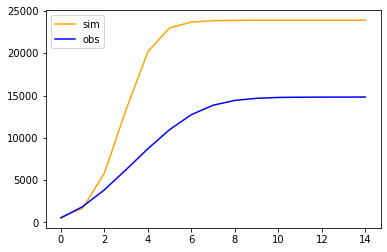

In [70]:
# Check the model returns the observations correctly
# i.e. that theyre the same length
np.array_equal(obs0, cases_devon_daily.loc[:len(sim0)-1,"CumulativeCases"])

# Print the fitness and plot the different disease counts
# print(f"fitness: {fitness0}")
# print(pd.DataFrame({"sim":sim0, "real_obs1":obs0}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, sim0, label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()


### Plot output summary data

#### Total counts of disease status

In [15]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "CumulativeCases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

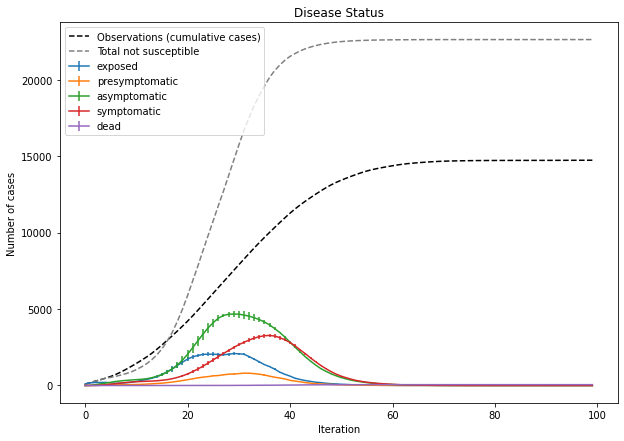

In [15]:
plot_summaries(summaries=summaries0, observations=cases_devon_daily, plot_type="error_bars")

In [11]:
# plot_summaries(summaries=summaries0, plot_type="lines")

#### Disease statuses by age

In [16]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

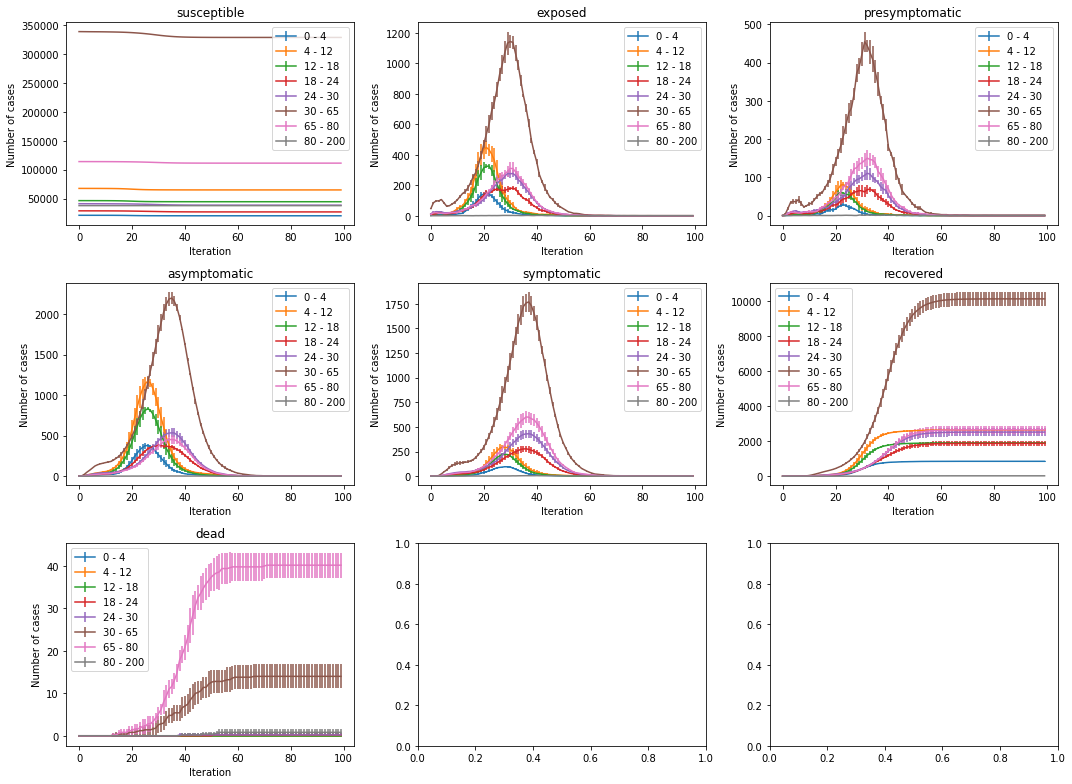

In [17]:
plot_disease_status_by_age(summaries0)

### Plots for MSOA geodata

Load MSOA shapes

In [95]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

gis_data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(gis_data_dir)

devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


Function to plot disease status by MSOA for a given timestep and status

In [93]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/). Full details in [abc-1.ipynb](abc-1.ipynb)

### Fitness

Need a `distance` function to calculate error. This one gets the observations and simulation data from a dataframe and calls a function that returns the Euclidean distance (L2 norm) calculate 

In [16]:
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Priors

Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


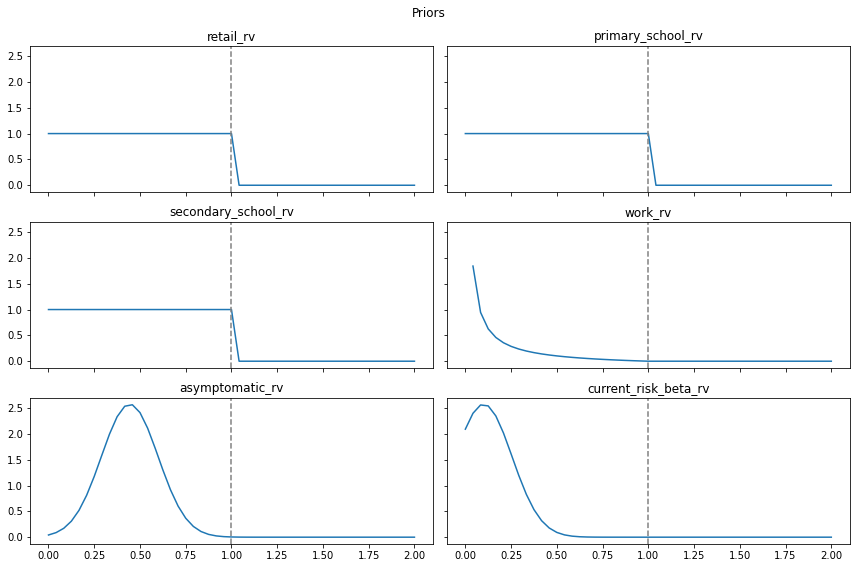

In [71]:
# Define the priors. Can decorate normal distributions later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_)
# The following should all be constant (overiding whatever is in the default.yml parameters file)
OpenCLRunner.set_constants( {"home": 1.0,  "presymptomatic": 1.0, "symptomatic": 1.0 })
# FYI this is how to represent with discrete discributions and one possible value (hack that didn't work):
# home_rv, current_risk_beta_rv = ( pyabc.RV('rv_discrete', values=([0.03], [1.0])) for _ in range(2) )
current_risk_beta_rv = pyabc.RV("norm", 0.1, 0.155)

# Now the random variables:
# School and retail are all uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = ( pyabc.RV("uniform", 0, 1) for _ in range(3)  )
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers (see justification at the start of this notebook).
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]
asymptomatic_rv = pyabc.RV("norm", 0.444, 0.155)

fig, axes = plt.subplots(3, 2, figsize=(12,8), sharex=True, sharey=True)
x = np.linspace(0,2,49)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, variable in enumerate([retail_rv, primary_school_rv, secondary_school_rv, work_rv,
                 asymptomatic_rv,current_risk_beta_rv ]):
    var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    #ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
fig.suptitle("Priors")
fig.tight_layout()
fig.show()


In [72]:
# Most priors can be passed straight to the distribution, except for 'asymptomatic' because it's normal
# so needs to be decorated to stay above 0
priors = pyabc.Distribution(
    #home = home_rv,
    retail = retail_rv,
    primary_school = primary_school_rv,
    secondary_school = secondary_school_rv,
    work = work_rv,
    #presymptomatic = presymptomatic_rv,
    #symptomatic = symptomatic_rv, 
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0)
    )


(Optionally) define the transitions. The transitions ('perturbation kernels') define how the current population is transitioned to the next one. The default (multivariate normal) transition doesn't work for discrete values, so  we need a separate transition for the static parameters.

_Note: I experimented with this as a way to hack a constant variable by using a `DiscreteJumpTransition`, but it didn't work because the domain of transition was necessarily a single number (1) but the transition complained that it had nowhere to go_

### Initialise the ABC algorithm.

In [31]:
# ### Initialise the ABC algorithm.
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    # distance_function = OpenCLWrapper.distance,
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
    )

Define observations

In [32]:
# 'Real' cumulative cases: 
#y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values
y_observed = cases_devon_weekly.loc[:(ITERATIONS/7)-1, "CumulativeCases"].values


Where to store results


In [33]:
db_path = ("sqlite:///" + os.path.join(".", "abc-2.db"))

In [34]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

ABC.History INFO: Start <ABCSMC id=30, start_time=2022-02-08 10:13:24>


### Run ABC

In [40]:
with open('105days.pkl', 'rb') as f:
    history = pickle.load(f)

In [36]:
history = None
fname = "./abc-2.pkl"
# history = abc.run(max_nr_populations=2) 
if LOAD_PICKLES and os.path.isfile(fname):
    with open( fname, "rb" ) as f:
        history = pickle.load(f)
else:
    history = abc.run(max_nr_populations=2) 
    # The history object only works if it has the associated database too ('abc-1.db')
    with open( fname, "wb" ) as f:
        pickle.dump( history, f)

ABC INFO: Calibration sample t = -1.
Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.98s/it]


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]
ABC INFO: t: 0, eps: 2.99377824e+05.


17780.985552848102
412512.2053589787
331862.8658970258
612341.9071943109
475050.29854690545
79319.14734163848
366318.55683615676
890905.9528163122
373006.184301077
93509.91612050227
191481.7015282282
810893.1940609427
305735.7220401767
387009.86895827804
397450.4414060541
270406.8160836519
30081.772553430794
424311.4550503928
10241.988236336198
673777.3687138689
36243.58705211802
376000.1373760498
619447.7530729992
309450.8954683949
51096.66136587533
281666.94624471915
84999.13788150671
271368.8889745263
371477.9602035735
22973.318853814886
290619.18518519145
51170.22009978078
83986.27802348127
293616.9708614994
500970.90600054734
338205.6734295856
86118.22304866232
116375.96951711332
15970.299816093915
418753.59056434955
858286.9616272531
159556.2990382336
849132.9252451396
59072.16708441768
158932.81675591914
547437.3149510064
812334.780921008
6678.571888052854
453616.3497008154
205582.20438320795
325691.3270309516
810674.7524083361
232480.36864052538
490435.92312824517
326697.016814

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.73s/it]


10021.101240833386


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.75s/it]


5096.669882754417


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


529294.4569187302


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.19s/it]


425173.4441352544


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.24s/it]


850318.7421846907


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.26s/it]


122044.30278390225


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.07s/it]


357747.9193368975


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.82s/it]


14468.99273382206


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


283532.88212975214


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.55s/it]


2267.6425603232847


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]


160400.15143941116


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]


7416.620326880255


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


185189.10851948717


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


481804.4050903388


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.10s/it]


194717.3287737388


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


889672.0654254168


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.89s/it]


203424.3955098203


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.97s/it]


10687.925641602376


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.83s/it]


141412.9869772496


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.08s/it]


316531.29322746716


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.18s/it]


374896.89926891716


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


619315.0129490538


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


275991.33769218647


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


665524.0174904334


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.88s/it]


146222.25972757372


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


350076.90455151396


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.95s/it]


125976.16216766248


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.70s/it]


95389.23705429972


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.16s/it]


442995.1114869866


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


701321.2082915107


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


813949.3136468388


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]


203515.55696866734


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


202029.13974178434


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


6809.140069091969


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.76s/it]


828333.8787276875


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.05s/it]


521285.7440961885


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.54s/it]


2159.9596687852963


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


381061.26360226783


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]


167870.59228644552


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


98074.57308906688


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.88s/it]


687812.1600999908


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


142512.11458271483


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.44s/it]


536011.586098373


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.37s/it]


614485.8502866792


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.71s/it]


150320.8899480017


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


418925.7345709263


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


286431.225878937


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.85s/it]


526533.7125913374


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.03s/it]


681680.4382218884


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]


5681.079204300565


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.45s/it]


170574.81295970778


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.36s/it]


59493.48031173793


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.36s/it]


84566.4580556688


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.11s/it]


25839.380219893254


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.45s/it]


513411.23346161103


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.07s/it]


328185.1556431953


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.85s/it]


496495.2349859619


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.27s/it]


468439.6688921797


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.64s/it]


10485.299672126175


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.57s/it]


211103.66446542894


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.69s/it]


152980.039416834


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.03s/it]


223629.5142424158


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.37s/it]


71673.0974072132


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.54s/it]


70887.91109087772


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.30s/it]


419544.450440117


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.10s/it]


245035.71217297003


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.97s/it]


24308.64725775986


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  7.00s/it]


428081.5676545576


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]


347423.78316222114


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:29<00:00,  5.82s/it]


891975.4952142326


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.87s/it]


183759.33186090286


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.94s/it]


71752.8909388827


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.89s/it]


28036.51605999078


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


362139.2362932533


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


674209.4550274415


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]


46503.64348214422


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


250477.59791346756


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.05s/it]


121442.87890765237


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.32s/it]


520483.58484612824


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]


6546.64126312742


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.58s/it]


439611.4615210751


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


116708.30992849017


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


453297.4532999665


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.51s/it]


611042.3321564328


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.07s/it]


144647.45273537285


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


466296.26243841444


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.02s/it]


232710.9108342331


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.17s/it]


214913.8395283086


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


286663.64683205565


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


421973.417136727


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


510653.48653981165


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.64s/it]


611649.9107190096


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.87s/it]


72985.21302535526


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.17s/it]


299439.54281697155


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.98s/it]


422553.58662907407


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.02s/it]


72780.93933522374


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


50406.52140101708


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


106326.35373247093


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  4.00s/it]


55754.42710738322


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.08s/it]


7605.945812732287


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.76s/it]


475126.3328591986


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.63s/it]


742683.3950188967


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


414081.2727570173


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.28s/it]


285500.20776754466


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.02s/it]


308808.3616109236


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.87s/it]


124922.6235759271


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.88s/it]


18006.911965055253


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.31s/it]


307024.5399592954


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.91s/it]


170931.4997488043


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


737972.8984865021


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


732414.0352235449


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.21s/it]


368198.0036630202


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.76s/it]


8668.698227171571


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.93s/it]


255230.4581833566


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


274777.96860672353


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.38s/it]


280088.4794211509


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.57s/it]


83691.12521880255


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.02s/it]


834921.6542075233


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


276756.8194075111


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.05s/it]


610210.8280108257


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.84s/it]


507902.5455187251


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.56s/it]


74704.92657265271


Running models:   0%|                                                                            | 0/5 [00:02<?, ?it/s]
ABC.History INFO: Done <ABCSMC id=30, duration=3:18:54.615962, end_time=2022-02-08 13:32:19>


KeyboardInterrupt: 

### Algorithm diagnostics

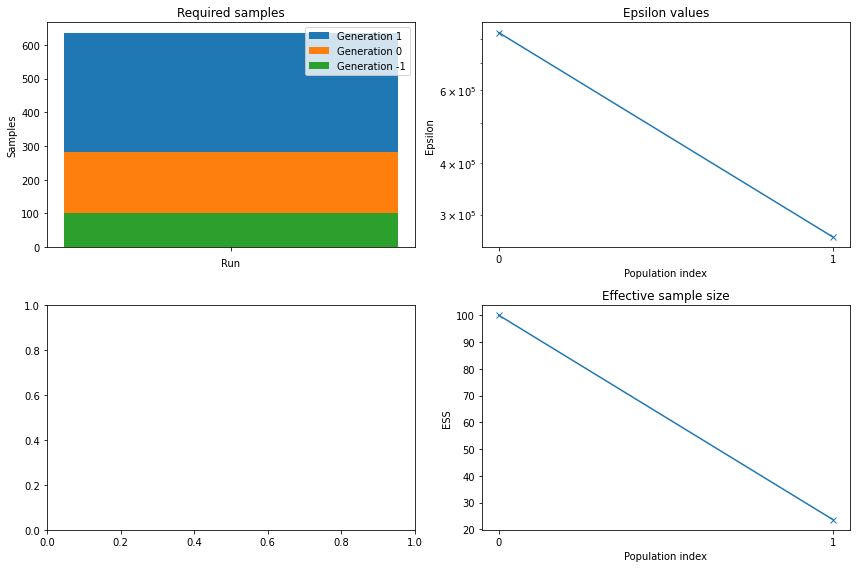

In [41]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

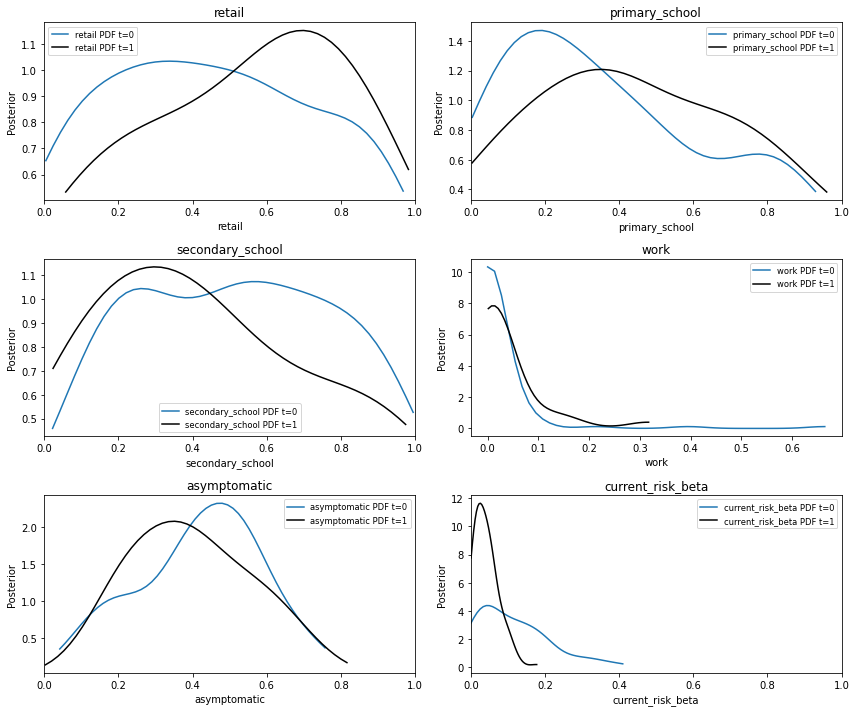

In [44]:
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,10))
fig, axes = plt.subplots(3,2, figsize=(12,10))
#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        if param!="work":
            ax.set_xlim(0,1)
        ax.legend(fontsize="small")
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [148]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

array([[<AxesSubplot:ylabel='asymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='current_risk_beta'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='primary_school'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='retail'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='secondary_school'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='asymptomatic', ylabel='work'>,
        <AxesSubplot:xlabel='current_risk_beta'>,
        <AxesSubplot:xlabel='primary_school'>,
        <AxesSubplot:xlabel='retail'>,
        <AxesSubplot:xlabel='secondary_school'>,
        <AxesSubplot:xlabel='work'>]], dtype=object)

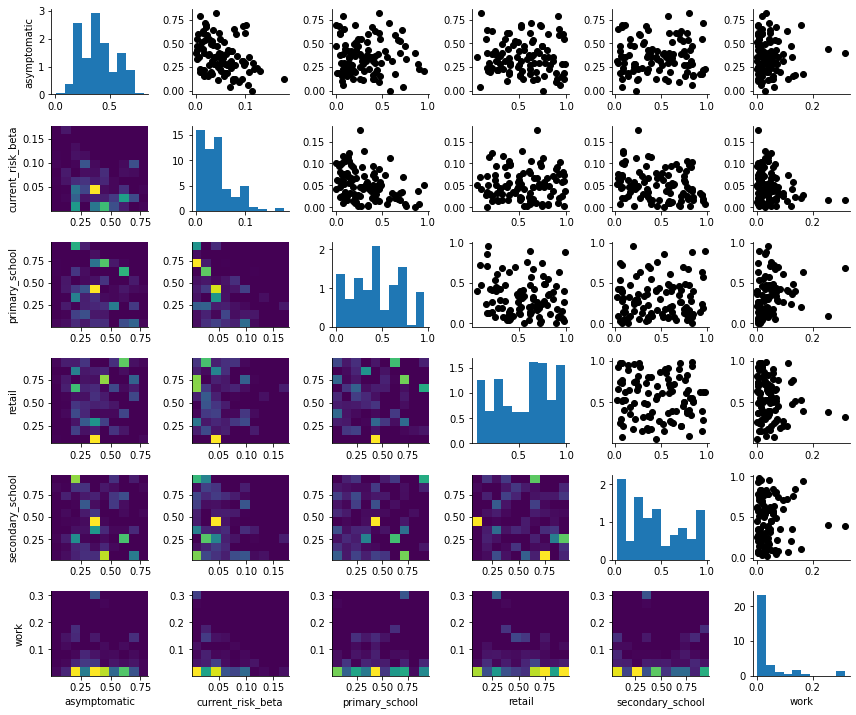

In [45]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [46]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,primary_school,retail,secondary_school,work,weight
0,385,0.357709,0.050188,0.396544,0.058017,0.451099,0.001305,0.113187
1,426,0.466915,0.008228,0.750158,0.744050,0.060936,0.004178,0.090340
2,368,0.591302,0.021926,0.641883,0.923727,0.277831,0.005954,0.079905
3,378,0.226114,0.008281,0.901598,0.620915,0.974587,0.007095,0.070833
4,396,0.227214,0.048787,0.361715,0.817526,0.254377,0.001360,0.048354
...,...,...,...,...,...,...,...,...
95,362,0.003296,0.112668,0.581966,0.759055,0.230467,0.029092,0.000967
96,401,0.110204,0.045629,0.297847,0.644962,0.237152,0.042018,0.000752
97,390,0.037137,0.068838,0.722717,0.091646,0.081382,0.061242,0.000731
98,366,0.151454,0.015742,0.118239,0.509856,0.848102,0.058886,0.000568


This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [73]:
N_samples = 50
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        # while (any(value < 0 for value in sample.values())):
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    param_values = {param: sample[str(param)] for param in priors}

    # Run the model
    # _fitness = fitness (comparison between sim and obs)
    # _sim =  model_weekly_cumulative_infections
    # _obs = obs_weekly_cumulative_infections
    # _out_params = 
    # _summaries = 
    (_fitness, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    # print(f"Fitness: {_fitness}. Sample: {sample}")

    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")
    
# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])

    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-2-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-2-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.93s/it]


Fitness: 134840.89675797077.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.87s/it]


Fitness: 43385.20884039032.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.54s/it]


Fitness: 455318.63972130365.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.79s/it]


Fitness: 281507.44334171625.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.31s/it]


Fitness: 32683.316803657373.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.12s/it]


Fitness: 136461.44901092703.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.13s/it]


Fitness: 52839.212890166775.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.01s/it]


Fitness: 212000.13238659198.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.03s/it]


Fitness: 38607.94806840568.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.05s/it]


Fitness: 27829.139459327398.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.90s/it]


Fitness: 776403.2626059805.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.09s/it]


Fitness: 92415.7232602063.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.14s/it]


Fitness: 107890.49790925998.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.13s/it]


Fitness: 362156.93617689866.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.91s/it]


Fitness: 44015.089996664545.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.04s/it]


Fitness: 105016.14846831931.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.84s/it]


Fitness: 487372.83758751716.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.96s/it]


Fitness: 221118.67119766408.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


Fitness: 349963.6479729006.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.37s/it]


Fitness: 28049.19425667845.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.33s/it]


Fitness: 10497.060090988169.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.35s/it]


Fitness: 132994.82563103864.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.43s/it]


Fitness: 24968.33827183913.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.09s/it]


Fitness: 34685.41302482559.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


Fitness: 182730.78889021513.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.86s/it]


Fitness: 21488.419128756083.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.88s/it]


Fitness: 31301.161785487846.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.74s/it]


Fitness: 16093.740934478925.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.75s/it]


Fitness: 30478.232263501162.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.69s/it]


Fitness: 44256.21885258285.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]


Fitness: 301830.62367799575.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.27s/it]


Fitness: 31435.403702180647.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.10s/it]


Fitness: 533509.3362314958.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.20s/it]


Fitness: 40066.336342740724.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.13s/it]


Fitness: 283846.19757391233.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.64s/it]


Fitness: 8009.177772775338.
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.58s/it]


Fitness: 43441.20130241242.
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.17s/it]


Fitness: 243118.97268518014.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.17s/it]


Fitness: 216031.85772898208.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.18s/it]


Fitness: 131169.97058005884.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.42s/it]


Fitness: 54623.275570532394.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.08s/it]


Fitness: 76809.93052695082.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.38s/it]


Fitness: 173529.40782272743.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]


Fitness: 34777.929358096546.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.65s/it]


Fitness: 13758.881679461509.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]


Fitness: 5929.8723944261355.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.59s/it]


Fitness: 229746.59234398286.


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.86s/it]


Fitness: 24416.215989298842.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


Fitness: 457919.4521095874.
Found negatives. Resampling


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.01s/it]

Fitness: 29058.336783537212.
Finished sampling. Ignored 53 negative samples.


Plot the individual results for each sample

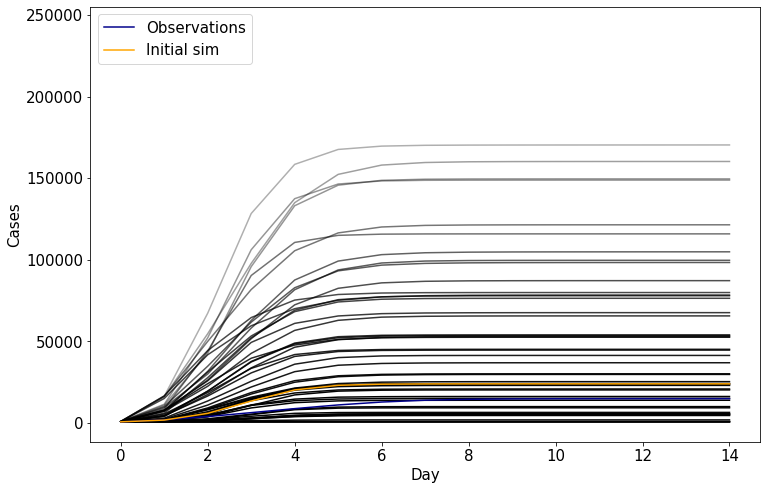

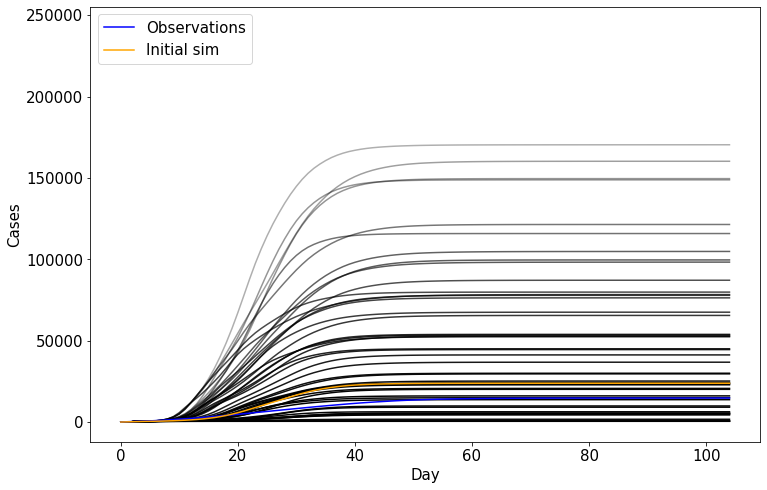

In [78]:
# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness - min(_fitness)) / (max(_fitness) - min(_fitness))

############## PLOT WEEKLY DATA
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, sim_l[i],
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax.plot(x, obs_l[0], label="Observations", color="darkblue")
# Plot result from manually calibrated model
ax.plot(x, sim0, label="Initial sim", color="orange")
ax.legend(fontsize=15)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("Day", size=15)
plt.ylabel("Cases",size=15)
plt.show()

############## PLOT DAILY DATA 
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - fitness_norm[i]  # (1-x because high fitness is bad)
            )
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    # ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
# Plot observations
ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
# # Plot result from manually calibrated model
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend(fontsize=15)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel("Day", size=15)
plt.ylabel("Cases",size=15)
plt.show()

del _fitness, fitness_norm


Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


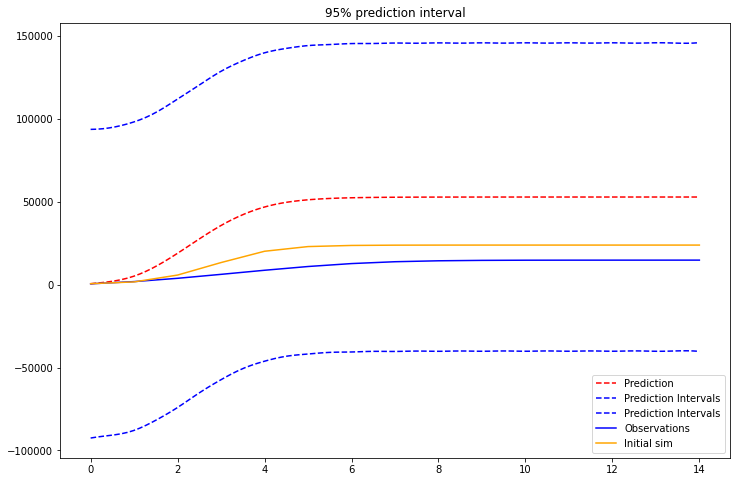

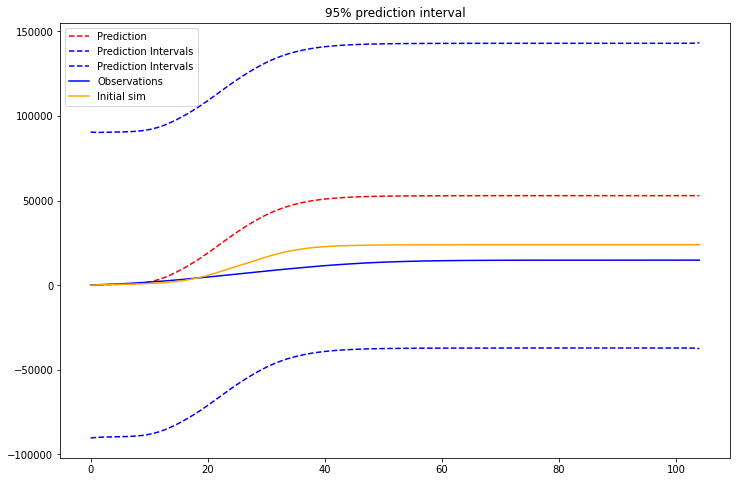

In [80]:
# Weekly

#best_paramswo long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers (i.e week numbers)
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(sim_l[i])
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations", color="blue")
ax.plot(x, sim0, label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');


# ## Daily??

# #best_paramswo long arrays with every result from every particle
# x = list(range(len(sim_l[0])*7))  # List of iteration numbers (i.e week numbers)
# X = []
# for _iter in x * len(summaries_l):  # One sequence of iterations (0-14) for each particle (here there are 10 particles)
#     X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
# X = np.array(X)
# y = []
# for i in range(len(summaries_l)):
#     y +=  list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
# y = np.array(y)

# # Generate the GAM
# gam = LinearGAM( n_splines=250)
# #gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
# gam.gridsearch(X, y)
# #XX = gam.generate_X_grid(term=0, n=len(X))
# XX = gam.generate_X_grid(term=0)


# # Plot
# fig, ax = plt.subplots(1,1, figsize=(12,8))

# ax.plot(XX, gam.predict(XX), 'r--', label="Prediction")
# ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label="Prediction Intervals")

# #pdep, confi = gam.partial_dependence(term=0, width=.95)
# #ax.plot(XX, pdep)
# #ax.plot(XX, confi, c='r', ls='--')

# ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
# ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('95% prediction interval');



Do a KDE plot with a logarithmic colour scale.

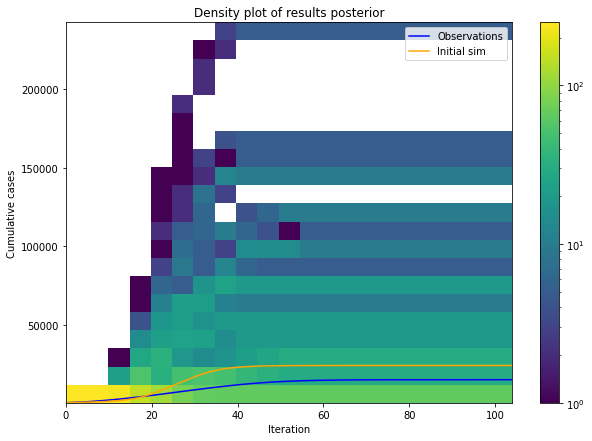

In [85]:
# # Do a KDE plot with a logarithmic colour scale.
# from matplotlib.colors import LogNorm
# fig, ax = plt.subplots(1,1, figsize=(10,7))
# h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
# ax.set_xlabel("Iteration")
# ax.set_ylabel("Cumulative cases")

# ax.plot(x, obs_l[0], label="Observations", color="blue")
# ax.plot(x, sim0, label="Initial sim", color="orange")
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.legend()
# fig.colorbar(h[3], ax=ax)
# #plt.scatter(X, y, facecolor='gray', edgecolors='none')
# ax.set_title('Density plot of results posterior');


#Do a KDE plot with a logarithmic colour scale.
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,1, figsize=(10,7))
h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5), norm=LogNorm())
ax.set_xlabel("Iteration")
ax.set_ylabel("Cumulative cases")

ax.plot(x, cases_devon_daily['CumulativeCases'][0:105], label="Observations", color="blue")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
fig.colorbar(h[3], ax=ax)
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('Density plot of results posterior');

#### ABC Posterior (B) - Find the Mode(s)

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [86]:
####### Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
best_params


{'retail': 0.8911786782254544,
 'primary_school': 0.39622402999428064,
 'secondary_school': 0.4183087375464526,
 'work': 0.03149353460063731,
 'asymptomatic': 0.22174410669290492,
 'current_risk_beta': 0.025239665550846085}

See how those parameters relate to the marginal posteriors

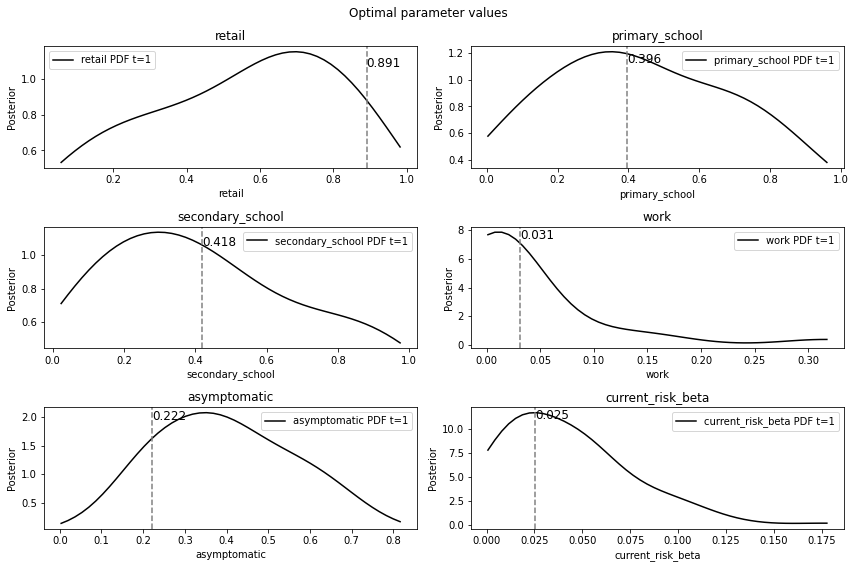

In [87]:
######## See how those parameters relate to the marginal posteriors
# fig, axes = plt.subplots(3,int(len(priors)/2), figsize=(12,8))
fig, axes = plt.subplots(3,2, figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.89s/it]

Fitness: 5718.275663147832


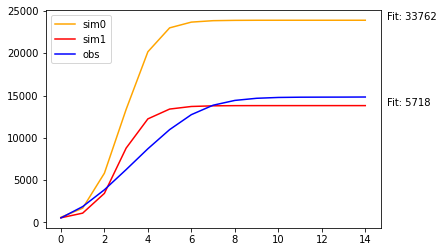

In [88]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs1)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, sim0, label="sim0", color="orange")
ax.plot(x, sim1, label="sim1", color="red")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1)]:
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")

Run the model with arbitray parameters (to experiment)

In [89]:
best_params

{'retail': 0.8911786782254544,
 'primary_school': 0.39622402999428064,
 'secondary_school': 0.4183087375464526,
 'work': 0.03149353460063731,
 'asymptomatic': 0.22174410669290492,
 'current_risk_beta': 0.025239665550846085}

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.83s/it]


Fitness: 5718.275663147832


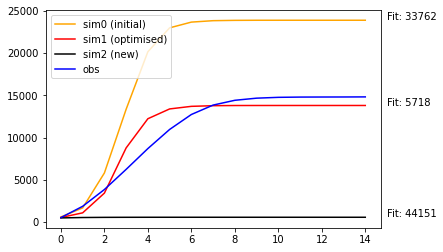

In [91]:
#OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness2, sim2, obs2, out_params2, summaries2) = OpenCLRunner.run_model_with_params_abc(
    {'retail': 0.9,
     'primary_school': 0.9,
     'secondary_school': 0.9,
     'work': 0.00001,
     'asymptomatic': 0.124},
    return_full_details=True)
#OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, sim0, label="sim0 (initial)", color="orange")
ax.plot(x, sim1, label="sim1 (optimised)", color="red")
ax.plot(x, sim2, label="sim2 (new)", color="black")
# Add fitness text
for a, b in [(summaries0,fitness0), (summaries1, fitness1), (summaries2, fitness2) ]:
    ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, obs1, label="obs", color="blue")
ax.legend()
print(f"Fitness: {fitness1}")


## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

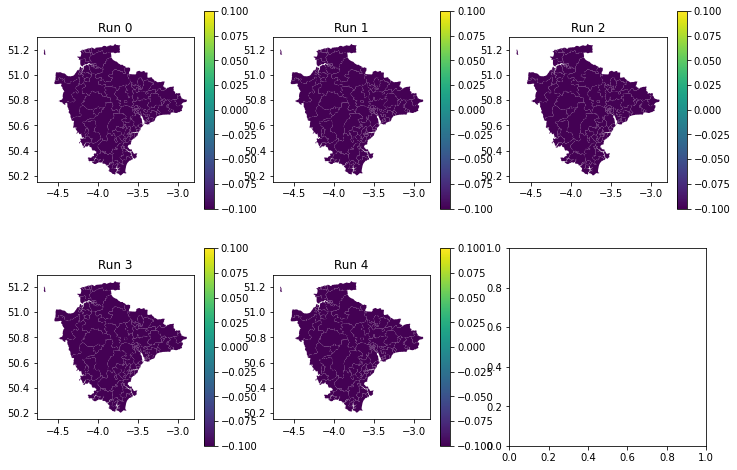

In [96]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)


N=len(summaries1)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2) if (N % 2) == 0 else int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries1[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

XXXX HERE there is too much spatial variation? Might need to reduce impact of workplace interactions. Or maybe this is interesting. 